In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from pathlib import Path
import json
import random
import re
import uuid
import shutil
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

random.seed()

In [3]:
project_path = '/datadisk2/qfeng/TextRecognitionDataGenerator'

if project_path not in sys.path:
    sys.path.append(project_path)
    
%cd $project_path
%pwd

/datadisk2/qfeng/TextRecognitionDataGenerator


'/datadisk2/qfeng/TextRecognitionDataGenerator'

**1. Set the parameters: input corpus directory and output image directory**

In [4]:
inp_path = Path('/datadisk2/qfeng/ocr_synthesis/test_inp/')
outp_path = Path('/datadisk2/qfeng/ocr_synthesis/test_outp/')

if outp_path.exists():
    shutil.rmtree(str(outp_path))
outp_path.mkdir()

In [5]:
long_letters_pattern = re.compile(r'[a-zA-Z]{3,}')
unchinese_pattern = re.compile(r'[^\u4e00-\u9fa5\s\w]')
html_pattern = re.compile(
    r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
)
other_url_pattern = re.compile(r'\/\/.*|[A-Za-z]:\\.*|[A-Za-z]:\/.*')

def find_chinese(inp):
    outp = re.sub(long_letters_pattern, '', inp)
    outp = re.sub(unchinese_pattern, '', outp)
    return outp


def cut_html_tags(inp):
    return re.sub(html_pattern, '', inp)


def cut_other_url_tags(inp):
    return re.sub(other_url_pattern, '', inp)


def cut_url_tags(inp):
    outp = cut_html_tags(inp)
    outp = cut_other_url_tags(outp)
    return outp

def cut_text(inp):
    return find_chinese(cut_url_tags(inp))

special_symbol = ['&', '：', '[', ']', '、', '（', '）', ':']

def make_texts(inp, max_len, fix_len, symbol_rate):
    """
    (1) If fix_len is False, output text is randomly generated with length
    between 1 and max_len; (2) symbo_rate is between 0 and 1 which is the
    rate of inserting a special symbol into the text.
    """
    outp = []
    buf = []
    for i in inp:
        buf.append(i)
        
        if symbol_rate > 0 and random.randint(0, int(1/symbol_rate)) == 0:
            buf.append(special_symbol[random.randint(0, len(special_symbol)-1)])
        
        if (fix_len and len(buf) == max_len) or (not fix_len and random.randint(0, max_len) == 0):
            outp.append(''.join(buf))
            buf = []
            
    return outp

def gen_texts(inp_path, filter_text=True, max_len=10, fix_len=True, symbol_rate=0):
    generated = []
    for fname in Path(inp_path).glob("*.txt"):
        with open(str(fname), 'r') as f:
            lines = [line.strip('\n') for line in f.readlines()]
            
            if filter_text:
                lines = [cut_text(line) for line in lines]
            for line in lines:
                if len(line) > 0: generated.extend(make_texts(line, max_len, fix_len, symbol_rate))
    return generated

In [6]:
inp_texts = gen_texts(inp_path)

In [7]:
from trdg.generators import CompoundGenerator
from collections import namedtuple

Missing modules for handwritten text generation.


**2. Set the parameters: fix configurations**

In [8]:
conf = namedtuple('Conf', ['width', 'background_type', 'fit', 'line_margin', 'skewing_angle', 'random_skew', 'box_skewing_angle', 'box_random_skew', 'size'])
conf.size = 32
conf.background_type = 1
conf.fit = True
conf.line_margin = 5
conf.skewing_angle = 0
conf.random_skew = True
conf.box_skewing_angle = 3
conf.box_random_skew = True

In [9]:
generator = CompoundGenerator(conf=conf)

**3. Set the parameters: random configurations**

In [10]:
font_file = '/datadisk2/qfeng/TextRecognitionDataGenerator/trdg/fonts/cn/SimSun.ttf'
font = Path(font_file).stem

def gen_image(inp_texts):    
    args = namedtuple('Args', ['font', 'texts', 'bold', 'box_margins', 'box_lines', 'alignment'])
    n_texts = random.randint(1, 5)
    args.texts = [inp_texts[random.randint(0, len(inp_texts))] for _ in range(n_texts)]   
    args.font = font_file
    args.bold = False
    args.box_margins = (random.randint(16, 64), random.randint(16, 64))
    args.box_lines = (random.randint(0, 1), random.randint(0, 1), random.randint(0, 1), random.randint(0, 1))
    args.alignment = random.randint(0, 1)
    args.draw_box = False
    img, img_locs = generator.gen(args)
    return img, img_locs, args.texts

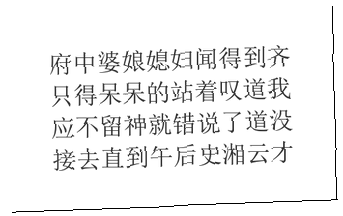

In [11]:
# Test generating one image
img, img_locs, c = gen_image(inp_texts)
img

In [12]:
def save_generated(tag, inp_texts, size, font):
    gt_dname = outp_path/(tag + '_gt')
    img_dname = outp_path/(tag + '_img')
   
    if gt_dname.exists():
        shutil.rmtree(str(gt_dname))
    gt_dname.mkdir()
        
    if img_dname.exists():
        shutil.rmtree(str(img_dname))
    img_dname.mkdir()
    
    for _ in range(size):
        img, img_locs, contents = gen_image(inp_texts)
        name = str(uuid.uuid4())
        img.save(str((img_dname/(name + '.png'))))
        
        with open(str(gt_dname/(name + '.txt')), 'w') as f:            
            for c, loc in zip(contents, img_locs):
                line = []
                for i_ in loc:
                    line.append(str(round(i_[0], 2)))
                    line.append(str(round(i_[1], 2)))
                line.append('"' + c + '"')
                line.append(font)
                f.write(','.join(line) + '\n')
                

def parallel_save(tag, inp, n_splits, bs, font, n_workers):
    """
    Will generate 2 * n_splits folders (half images and half labels).
    Each folder has bs images or labels.
    """
    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        func = partial(save_generated, size=bs, font=font)
        step = len(inp)//n_splits
        splits = list(range(0, len(inp), step))
        for i in range(1, len(splits)):
            print(splits[i-1], splits[i])
            ex.submit(func, tag + '_' + str(i), inp[splits[i-1]:splits[i]])

In [13]:
parallel_save(tag='texts', inp=inp_texts, n_splits=10, bs=100, font=font, n_workers=40)

0 7621
7621 15242
15242 22863
22863 30484
30484 38105
38105 45726
45726 53347
53347 60968
60968 68589
68589 76210
